# Generative AI 
Generative AI refers to a subset of artificial intelligence models and algorithms designed to generate new data samples  that closely mirror the statistical properties of a target dataset. Unlike traditional classification and regression models, which predict labels or values based on input features, generative models aim to understand and replicate the complex distributions of input data, allowing them to produce entirely new data points that are similar or even indistinguishable to those in the training set.

## Main Classes of Generative AI Models

### 1. **Generative Adversarial Networks (GANs):**
- **Overview:** Consist of two neural networks, the generator and the discriminator, that are trained simultaneously in an adversarial process.
- **Applications:** Widely used for tasks like image generation, super-resolution, style transfer, and data augmentation.

### 2. **Variational Autoencoders (VAEs):**
- **Overview:** Based on Bayesian inference principles, VAEs encode input data into a distribution in latent space and decode from this space to reconstruct the input.
- **Applications:** Employed in image generation, anomaly detection, and semi-supervised learning tasks.

### 3. **Autoregressive Models:**
- **Overview:** These models generate sequences by predicting each new piece of data conditioned on the previously generated pieces.
- **Applications:** Utilized for text generation, image synthesis, and time series forecasting.

### 4. **Diffusion Models:**
- **Overview:** Generate data by gradually denoising a sample from a simple distribution over a series of steps, guided by a trained neural network.
- **Applications:** Shown impressive results in high-fidelity image generation, audio synthesis, and molecular design.

Each class has its strengths and is chosen based on specific task requirements, such as sample quality, training stability, and computational efficiency. The field continues to evolve rapidly, introducing new models and improving existing ones.

## Differences from discriminative models
In this course, at least so far, we have been focusing on class of models referred to as `discriminative models`. Deep learning classifiers and regressors are two examples of such models. Both classification and regression models focus on mapping input data to known outputs or labels, making them excellent for predictive tasks but not suited for generating new data.

## Potential in Biology
Generative models have significant potential in biology, offering innovative ways to tackle complex problems:

* __Drug Discovery__: Generative models can propose novel molecular structures with desired properties, accelerating the identification of potential new drugs. See [examples](https://blogs.nvidia.com/blog/generative-ai-proteins-evozyne/)
* __Synthetic Biology__: These models can design new genetic sequences or synthetic organisms with specific functions, supporting advances in bioengineering.
* __Data Augmentation__: Generative AI can create additional training samples for rare conditions or species, enhancing the performance of classification models in biology.
* __Understanding Complex Systems__: By generating data under different simulated conditions, generative models help in understanding complex biological systems and interactions.

Today, we will concentrate in more mundane tasks, such as increasing the resolution of bioimages, or generating missing parts of images. To do that, we will use a class of generative models called '_Generative Adversarial Networks_'.

## Generative Adversarial Networks (GANs)
GANs are a powerful class of generative models consisting of two neural networks, the generator and the discriminator, which are trained simultaneously in a competitive setting:

* Generator: Learns to produce data that mimics the training dataset. In biology, this could involve generating synthetic genomic sequences or realistic cell images.
* Discriminator: Learns to distinguish between real data from the training set and fake data produced by the generator. Its feedback helps improve the generator.
The adversarial process leads to the generator creating highly realistic data, making GANs particularly effective for tasks requiring high-quality synthetic data generation. Please see the diagram below that was produced by [Google](https://developers.google.com/machine-learning/gan/gan_structure).

![GAN](images/gan_diagram.svg)

## Generating random digits

Today, our first task will be to create a simple GAN implementation and train it to generate digit images that resemble those from the MNIST dataset, a collection of handwritten digits widely used in machine learning. The code we'll explore consists of two main components: the Generator, which will learn to produce images akin to MNIST digits, and the Discriminator, whose job is to distinguish between real MNIST images and the fakes produced by our Generator. As we dive into the code, keep in mind that the Generator and Discriminator are essentially in a continuous game of cat and mouse, improving through each iteration of our training loop. This dynamic interaction is what makes GANs both challenging and incredibly fascinating. 


In [17]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


To start, let's load the MNIST dataset from keras

In [18]:
# Load MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the images
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


We can then define a simple generator model

In [19]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(200,)))  
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 128)))  # Reshape to a 7x7x128 tensor. Reshaped to tmatch the next sample seen by the generator

    # Upsample to 28x28x1
    model.add(layers.Conv2DTranspose(1, (4, 4), strides=(4, 4), padding='same', use_bias=False, activation='tanh'))
    return model

generator = make_generator_model()

In [20]:
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              1254400   
                                                                 
 batch_normalization_4 (Bat  (None, 6272)              25088     
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 28, 28, 1)         2048      
 Transpose)                                                      
                                                                 
Total params: 1281536 (4.89 MB)
Trainable params: 1268

We follow the generator by defining a discriminator


In [21]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = make_discriminator_model()

In [22]:
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 12545     
                                                                 
Total params: 14209 (55.50 KB)
Trainable params: 14209 (55.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We can now define our losses (i.e., error metric). We will use binary cross entropy because the task at hand is quite simple. Either the model will consider a sample "real" or "fake".

In [26]:
# two losses discrimitor loss which signifies how well the dicrimination is made and rhe genratr lss which signifies how well the generator tricked the drsicriminator

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(5e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-4)

We can also create some code to display images during training.

In [24]:
def generate_and_display_images(model, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

Finally, we can define our approach for training the model and storing the losses/data as needed.

In [25]:
# fro generatriv emodels you can look at the data in additon to looking at the loss
generator_losses = []
discriminator_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 200])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def train(dataset, epochs, seed):
    for epoch in tqdm(range(epochs), desc='Epochs'):
        epoch_gen_loss = []
        epoch_disc_loss = []
        
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss.append(gen_loss.numpy())
            epoch_disc_loss.append(disc_loss.numpy())

        # Average loss for the epoch
        generator_losses.append(np.mean(epoch_gen_loss))
        discriminator_losses.append(np.mean(epoch_disc_loss))

        # Display images and print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'\nEpoch {epoch + 1} completed')
            #print(f'Generator loss: {generator_losses[-1]}, Discriminator loss: {discriminator_losses[-1]}')
            generate_and_display_images(generator, seed)

    # Final display
    if epochs % 10 != 0:
        generate_and_display_images(generator, seed)



Let's train!!

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]2024-03-22 14:28:59.858691: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-03-22 14:29:01.833099: I external/local_xla/xla/service/service.cc:168] XLA service 0x1472551e9aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 14:29:01.833149: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-03-22 14:29:01.868317: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711132142.020345 1862055 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Epochs:   9%|▉         | 9/100 [00:09<00:56,  1.60it/s]


Epoch 10 completed


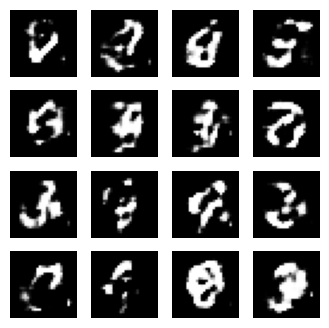

Epochs:  19%|█▉        | 19/100 [00:15<00:44,  1.82it/s]


Epoch 20 completed


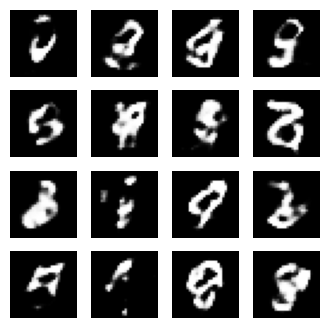

Epochs:  29%|██▉       | 29/100 [00:20<00:39,  1.82it/s]


Epoch 30 completed


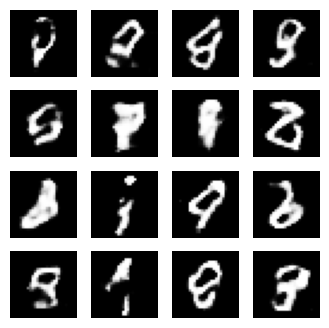

Epochs:  39%|███▉      | 39/100 [00:26<00:33,  1.84it/s]


Epoch 40 completed


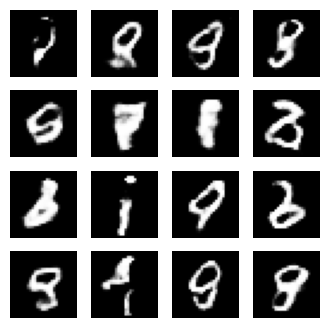

Epochs:  49%|████▉     | 49/100 [00:32<00:27,  1.83it/s]


Epoch 50 completed


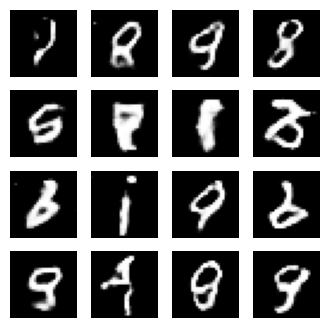

Epochs:  59%|█████▉    | 59/100 [00:37<00:22,  1.85it/s]


Epoch 60 completed


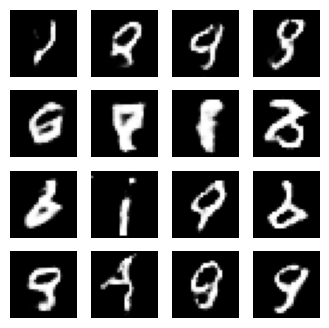

Epochs:  69%|██████▉   | 69/100 [00:43<00:16,  1.84it/s]


Epoch 70 completed


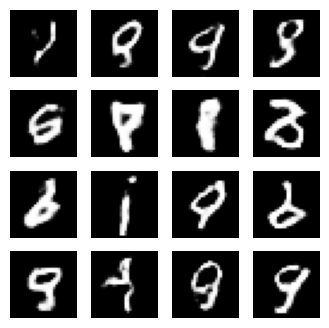

Epochs:  79%|███████▉  | 79/100 [00:49<00:11,  1.84it/s]


Epoch 80 completed


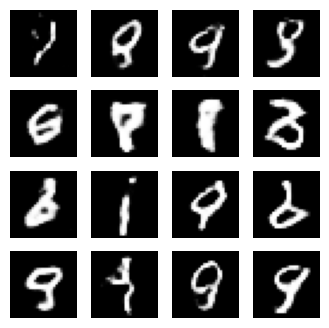

Epochs:  89%|████████▉ | 89/100 [00:54<00:06,  1.82it/s]


Epoch 90 completed


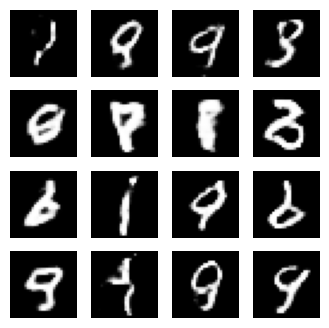

Epochs:  99%|█████████▉| 99/100 [01:00<00:00,  1.80it/s]


Epoch 100 completed


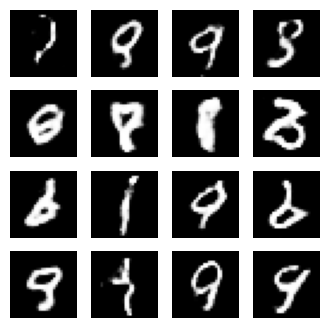

Epochs: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s]


In [27]:
seed = tf.random.normal([16, 200])  # 'num_examples_to_generate' is typically 16 for a 4x4 grid
EPOCHS = 100  # Set the number of epochs
train(train_dataset, EPOCHS, seed)

## Applications: Super resolution!


This part of the notebook has been adapted from an official [tensorflow example](https://github.com/tensorflow/examples/blob/1fc8f6af1d542ed358d12dec88156d4cbf70d9d4/lite/examples/super_resolution/ml/super_resolution.ipynb)

In particular, we will use a GAN for the task of recovering a high resolution (HR) image from its low resolution counterpart.

The model we are going to use here is ESRGAN
([ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks](https://arxiv.org/abs/1809.00219)). 

The model in our shared drive has been converted from this
[implementation](https://tfhub.dev/captain-pool/esrgan-tf2/1) hosted on the tensorflow Hub. This model upsamples a 50x50 low resolution image to a 200x200 high resolution image (scale factor=4). If you want a different input size or scale factor, you need to re-convert or re-train the original model.

Let's start by importing the dependencies:

In [29]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Now we will define the model path and load a test image:

In [31]:
esrgan_model_path = '/blue/bsc4892/share/super-resolution/ESRGAN.tflite'
test_img_path = tf.keras.utils.get_file('lr.jpg', 
                                        'https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/super_resolution/android/app/src/main/assets/lr-1.jpg')

This is a simple image of a moth, at very low resolution

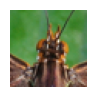

In [32]:
# Load the image
img = Image.open(test_img_path)

# Display the image
plt.figure(figsize=(1,1))
plt.imshow(img)
plt.axis('off')  # Hide axes ticks
plt.show()

Let's first try to upsample this image using interpolation techniques

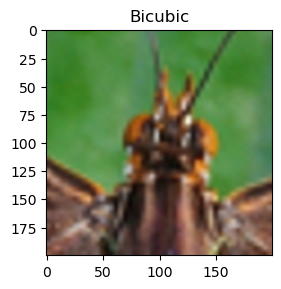

In [33]:
img = Image.open(test_img_path)
img = img.convert('RGB')
lr = np.array(img)
lr = tf.expand_dims(lr, axis=0)
lr = tf.cast(lr, tf.float32)

lr = tf.cast(tf.squeeze(lr, axis=0), tf.uint8)
bicubic = tf.image.resize(lr, [200, 200], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
plt.subplot(1, 2, 2)   
plt.title('Bicubic')
plt.imshow(bicubic.numpy());

Doesn't look that great.

Finally, we can run the model and see if we obtain a better image

In [34]:
lr = np.array(img)
lr = tf.expand_dims(lr, axis=0)
lr = tf.cast(lr, tf.float32)

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=esrgan_model_path)

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#Resize the input tensor.
interpreter.resize_tensor_input(input_details[0]['index'],[1,50,50,3])
interpreter.allocate_tensors()

# Run the model
interpreter.set_tensor(input_details[0]['index'], lr)
interpreter.invoke()

# Extract the output and postprocess it
output_data = interpreter.get_tensor(output_details[0]['index'])
sr = tf.squeeze(output_data, axis=0)
sr = tf.clip_by_value(sr, 0, 255)
sr = tf.round(sr)
sr = tf.cast(sr, tf.uint8)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Now generating a plot:

In [ ]:
lr = tf.cast(tf.squeeze(lr, axis=0), tf.uint8)
plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr.numpy());

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'ESRGAN (x4)')
plt.imshow(sr.numpy());

bicubic = tf.image.resize(lr, [200, 200], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
plt.subplot(1, 2, 2)   
plt.title('Bicubic')
plt.imshow(bicubic.numpy());

## Applications : Synthesis

In this next section, we will use a GAN for the task of image extension/synthesis.

The model we are going to use here is [Boundless](https://arxiv.org/pdf/1908.07007.pdf) (Boundless: Generative Adversarial Networks for Image Extension).

The model in our shared drive has been downloaded from [here](https://www.tensorflow.org/hub/tutorials/boundless). This model requires input images at 257x257 resolution. If you want a different input size or scale factor, you need to re-convert or re-train the original model. In this exercise, we will use the same image that we used above for this task.


### Core Aspects:

- **Functionality**: Primarily focused on image extension, the Boundless model predicts the continuation of scenes, textures, and patterns from the available visual information in the input image.
- **Architecture**: The model leverages a convolutional neural network (CNN) structure, trained on a diverse dataset to understand and replicate a wide range of image features and styles.
- **Applications**: While its uses span artistic and practical realms, such as digital art creation and content generation, the model's application is grounded in its ability to reliably predict image extensions based on learned patterns.

Let's start by loading the model and running the image through it.



In [ ]:
boundless_model_path = '/blue/bsc4892/share/super-resolution/Boundless.tflite'

img = Image.open(test_img_path)
img = img.convert('RGB')
lr = np.array(img)
lr = tf.image.resize(lr, [257, 257])
lr = tf.expand_dims(lr, axis=0)
lr = tf.cast(lr, tf.float32)

# Load TFLite model and allocate tensors.
model = tf.lite.Interpreter(model_path=boundless_model_path)

model.allocate_tensors()

# Get input and output tensors
input_details = model.get_input_details()
output_details = model.get_output_details()

# Set the resized input tensor
model.set_tensor(input_details[0]['index'], lr/255)

# Invoke the model
model.invoke()

# To retrieve the output, you need to use the output tensor indices from 'output_details'
# Here's an example of how you might retrieve the outputs:
generated_image_index = output_details[0]['index']
masked_image_index = output_details[1]['index']

generated_image = model.get_tensor(generated_image_index)
masked_image = model.get_tensor(masked_image_index)


Now let's plot it!

In [ ]:
# Ensure 'lr', 'generated_image', and 'masked_image' are in the correct format for visualization
# If 'lr' was expanded with a batch dimension and cast to float, convert it back for visualization
lr_vis = tf.squeeze(lr, axis=0)  # Remove batch dimension if present
lr_vis = tf.cast(lr_vis, tf.uint8)  # Convert back to uint8

# Convert 'generated_image' and 'masked_image' back to uint8 if they are not already
generated_image_vis = tf.cast(tf.squeeze(generated_image, axis=0)*255, tf.uint8)  # Assuming 'generated_image' might have a batch dimension
masked_image_vis = tf.cast(tf.squeeze(masked_image, axis=0)*255, tf.uint8)  # Assuming 'masked_image' might have a batch dimension

# Visualization
plt.figure(figsize=(15, 5))

# Display the original LR image
plt.subplot(1, 3, 1)
plt.imshow(lr_vis.numpy())
plt.title('Original LR Image')
plt.axis('off')  # Hide the axis

# Display the masked image
plt.subplot(1, 3, 2)
plt.imshow(masked_image_vis.numpy())
plt.title('Masked Image')
plt.axis('off')  # Hide the axis

# Display the generated (super-resolved) image
plt.subplot(1, 3, 3)
plt.imshow(generated_image_vis.numpy())
plt.title('Generated Image')
plt.axis('off')  # Hide the axis

plt.show()